# Understanding auto-correlation

In [1]:
from scipy import signal
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from wand.image import Image
from wand.display import display
from celluloid import Camera

In [2]:
sns.set(context='talk', style='ticks', palette='muted')

## simulate eye hand signals

In [3]:
def createSignal(
    amplitude,
    freqList, 
    lenSignal, 
    timePeriod, 
    burstFreq, 
    burstTime, 
    dc_offset,
    noise_level
):
    np.random.seed(seed=42)
    
    t = np.linspace(timePeriod[0], timePeriod[1], lenSignal)
    
    signal =  amplitude * np.sin(np.pi * 2. * burstFreq * t)
    
    signal[np.logical_or(t < burstTime[0], t > burstTime[1])] = 0
    
    on_time = np.logical_and(t >= burstTime[0], t <= burstTime[1])
    
    signal = signal + dc_offset + np.random.normal(noise_level, 1, size=lenSignal) 
    
#     signal[on_time] *= np.hanning(on_time.sum()) 
    
#     for f in freqList:
#         signal = signal + np.sin(2*np.pi*f*t)
        
    return signal

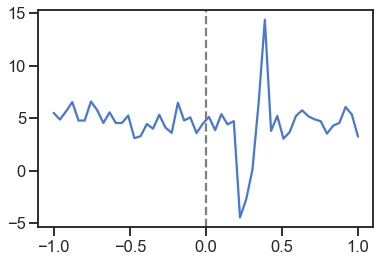

In [4]:
freqList = [1]
N = 50
noise_level = 2
timePeriod = [-1, 1]
t = np.linspace(*timePeriod, N)
burstFreq = 3
burstTime = [0.2, 0.4]
dc_offset = 3
amplitude = 10
x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, x, color='b', label='eye')

plt.axvline(0, color='grey', ls='--');

## auto-corr using scipy.signal.correlate

Delay between signals is: 0


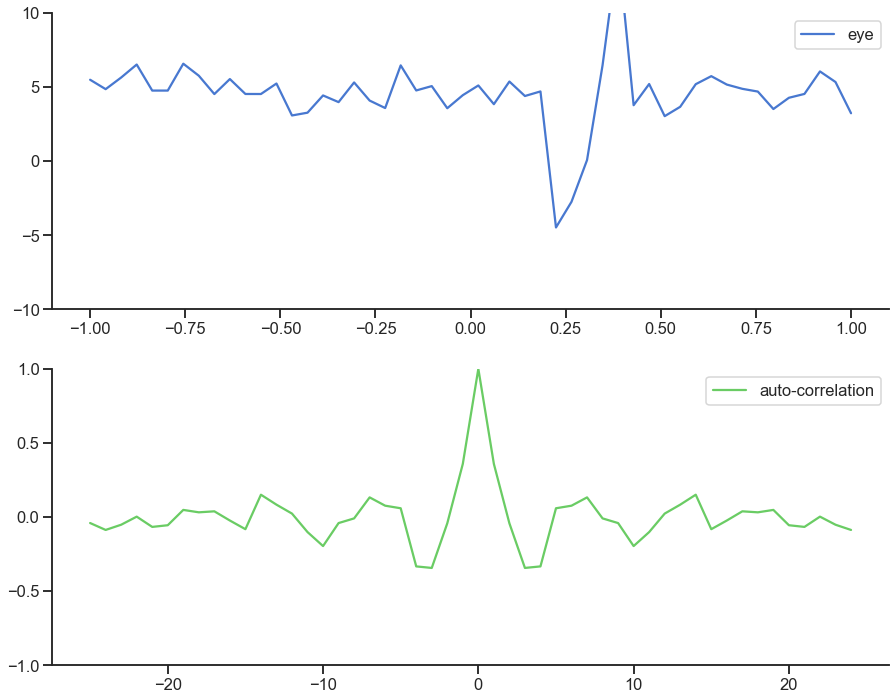

In [5]:
_, ax = plt.subplots(2, 1, figsize=(15,12))
ax = ax.ravel()

ax[0].plot(t, x, color='b', label='eye')

x = (x-x.mean())
corr = signal.correlate(x,x, 'same', 'fft')/len(x)
lags = signal.correlation_lags(len(x), len(x), mode='same')
corr /= np.max(abs(corr))

print(f'Delay between signals is: {lags[np.argmax(abs(corr))]}')
# ax[0].axvline(0, color='grey', ls='--')
ax[1].plot(lags, corr, color='g', label='auto-correlation')
ax[0].legend()
ax[1].legend()
ax[0].set(ylim=(-10,10), yticks=np.arange(-10, 11, 5))
ax[1].set(ylim=(-1,1), yticks=np.arange(-1, 1.1, 0.5));
sns.despine()

# print(x.shape, corr.shape)

## Compute XCORR using fft

In [6]:
def compute_xcorr_fft(x, y, remove_dc=True):
    if remove_dc:
        x = x - x.mean()
        y = y - y.mean()
    x1 = fft(x)/len(x)
    y1 = fft(np.flipud(y))/len(y)
    xcorr = np.real(ifft(x1 * y1))/len(x)
    xcorr = fftshift(xcorr)
    xcorr /= xcorr.max()
    
    return xcorr

In [7]:
freqList = [1]
N = 50
noise_level = 2
timePeriod = [-1, 1]
t = np.linspace(*timePeriod, N)
burstFreq = 3
burstTime = [0.2, 0.4]
dc_offset = 3
amplitude = 10
x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)

Delay between signals is: 24


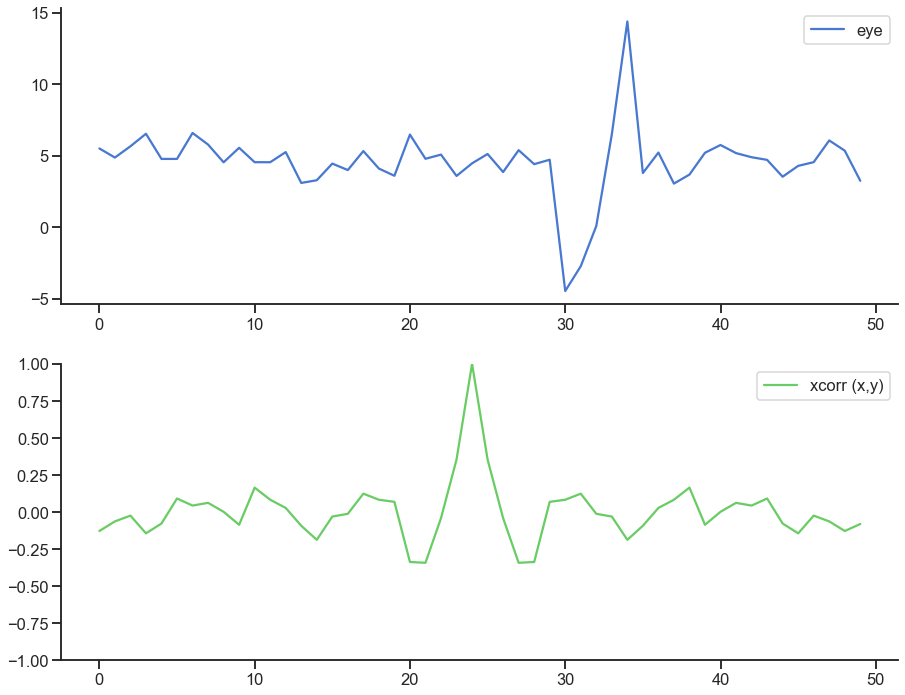

In [8]:
_, ax = plt.subplots(2, 1, figsize=(15,12), sharey=False)
ax = ax.ravel()

corr = compute_xcorr_fft(x, x, True)
corr /= max(abs(corr))
print(f'Delay between signals is: {np.argmax(abs(corr))}')
ax[0].plot(x, color='b', label='eye')
ax[1].plot(corr, color='g', label='xcorr (x,y)')
ax[0].legend()
ax[1].legend()

# ax[1].set(ylim=(-1, 1))
ax[1].set(ylim=(-1, 1))
sns.despine()

## Animated Auto-Correlation

In [63]:
def get_signal(N):
    N = 50
    noise_level = 2
    timePeriod = [-1, 1]
    t = np.linspace(*timePeriod, N)
    burstFreq = 3
    burstTime = [0.2, 0.4]
    dc_offset = 1
    amplitude = 10
    # signal 1
    x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
    
    return x, t

def get_Rxx(x, xx, mu_x, sigma_x, N):  
    
    Rxx_tau = np.nansum((x - mu_x)*(xx - mu_x))/(sigma_x * sigma_x * N) 
        
    return Rxx_tau

def calculate_acorr():
    # create signals     
    x, t = get_signal(60)
    
    # get signal statistics
    mu_x, sigma_x = x.mean(), x.std()
    
    N = len(x)
    
#     # pad the main signal    
#     padded_x = np.pad(x, (N, 2*N), 'constant')
    
    Rxx = np.array([])
    for idx, tau in enumerate(range(1, 2*N)):      
#         padded_xx = np.pad(x, (idx, 3*N - idx), 'constant', constant_values=np.nan )
        if tau <= N:
            Rxx = np.append(
                Rxx, 
                get_Rxx(
                    x[:tau],x[-tau:],
                    mu_x, sigma_x, N
                )
            )
        elif tau > N:
            Rxx = np.append(
                Rxx, 
                get_Rxx(
                    x[tau%N:],x[:-tau%N],
                    mu_x, sigma_x, N
                )
            )
    
    return x, Rxx, t, N

def autocorr2(x):
    '''manualy compute, non partial'''
    lags = np.arange(0, len(x), 1)
    var = np.var(x)
    xp = x - np.mean(x)
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:l])/len(x)/var for l in lags]
    
    return corr, x
    

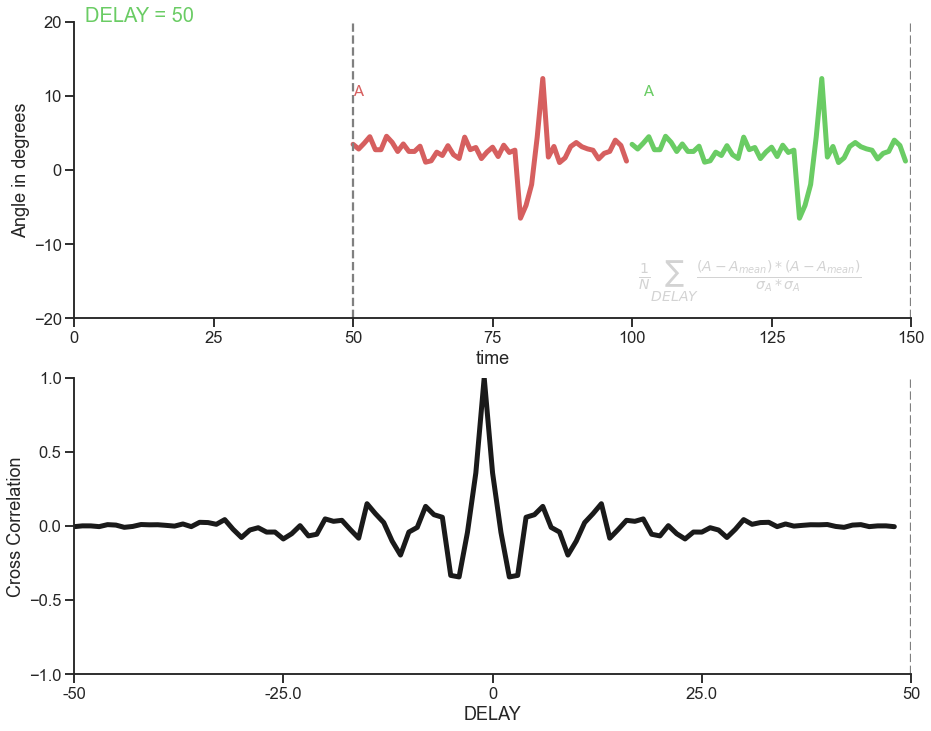

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(15,12), sharex=False)
# fig.subplots_adjust(hspace=2)
camera = Camera(fig)

x, Rxx, t, N = calculate_acorr()

# Rxx, _ = autocorr2(x) 


for ind, ax in enumerate(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.legend()
        if ind != 1:
            ax.set(ylim=(-20,20), xlim=(0,3*N), 
                   yticks=np.arange(-20,21,10), 
                   xticks=np.arange(0,3*N + 1, N/2.),
                   xlabel='time',
                   ylabel='Angle in degrees'
                  )
        else:
            ax.set(ylim=(-1,1), xlim=(0,2*N), 
                   yticks=np.arange(-1,1.1,0.5), 
                   xticks=np.arange(0, 2*N+1, N/2.),
                   xticklabels=[-N, -N/2., 0, N/2., N],
                   xlabel='DELAY',
                   ylabel='Cross Correlation'
                  )



for frame in range(2*N + 1):    
    
    padded_x = np.pad(x, (N, 2*N), 'constant')
    padded_x[padded_x==0] = np.nan
    axes[0].plot(padded_x, color='r', lw=5 )
    axes[0].axvline(frame + N, color='grey', ls='--')
    axes[0].axvline(N, color='grey', ls='--')
    
    padded_xx = np.pad(x, (frame, 3*N - frame), 'constant', constant_values=np.nan)
    axes[0].plot(padded_xx, color='g', lw=5, )
    
    axes[0].text(    
        2, 20, f'DELAY = {frame - N}', {'color': 'g', 'fontsize': 20},
    )
    axes[0].text(    
        50, 10, 'A', {'color': 'r', 'fontsize': 15},
    )
    axes[0].text(    
        frame + 2, 10, 'A', {'color': 'g', 'fontsize': 15},
    )
    axes[0].text(    
        frame + 1, -15, 
        r'$ \frac{1}{N}\sum_{DELAY} \frac{(A - A_{mean})*(A - A_{mean})}{\sigma_A * \sigma_A} $', 
        {'color': 'lightgrey', 'fontsize': 20},
    )

    axes[1].plot(Rxx[:frame], color='k', lw=5,)
    axes[1].axvline(frame, color='grey', ls='--')    
    
    camera.snap()

animation = camera.animate(interval = 1000,)
animation.save('acorr.gif')
